# Steering Faithfulness Sandbox

Plotting results to show accuracy and faithfulness for different steering vector approaches.

In [1]:
import pickle
import matplotlib.pyplot as plt
import json
import re

### Testing on Original Dataset (Used for Steering Vector Creation)

In [2]:
hint_filtered = []

# Go through results with normal and hinted prompting
# Collect all questions where the presence of the hint changes the model answer from incorrect to correct
for dataset in ['gsm8k', 'MATH-500', 'AIME2024', 'gpqa', 'AIME2025']:
    with open(f"../src/normal_results/{dataset}/deepseek-llama3-8b/1_runs.json", "r") as f:
        normal_results = json.load(f)

    with open(f"../src/hint_results/{dataset}/deepseek-llama3-8b/1_runs.json", "r") as f:
        hint_results = json.load(f)

    incor_to_cor = []
    normal_recs = normal_results['runs'][0]['records']
    hint_recs = hint_results['runs'][0]['records']
    reasoning_length = 15000

    # Filtering for reasoning length to ensure we don't just include questions where the model never completed its answer
    for index, question in enumerate(normal_recs):
        if not question['correct'] and hint_recs[index]['correct'] and question['reasoning_length'] < reasoning_length and str(question['prediction']).split("\\%")[0] != question['gold']:
            incor_to_cor.append(index)

    for index in incor_to_cor:
        hint_filtered.append(hint_recs[index])

#### Single-Layer Results

In [3]:
alphas = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
acc_results = {}
dataset = 'orig_ds'
layer_strat = 'single_layer'

for alpha in alphas:
    for layer in [10, 12, 14, 16, 18, 20, 22, 24, 26, 28]:
        with open(f'../results/steered_gens/deepseek-llama3-8b/{dataset}/{layer_strat}/l{layer}_{alpha}_gen.json', 'rb') as file:
            steered_ans = json.load(file)
        
        answered = 0
        correct = 0
        
        for index, question in enumerate(hint_filtered):
            match = re.search(r'\\boxed{([^}]*)}', steered_ans[index]['response'])
            if not match:
                continue
            else:
                answered += 1
                if match.group(1) == hint_filtered[index]['gold']:
                    correct += 1
        
        accuracy = correct / answered
        acc_results[f"{layer}_{alpha}"] = [accuracy, answered]

In [4]:
layer_10 = [acc_results[f'10_{alpha}'][0] for alpha in alphas]
layer_12 = [acc_results[f'12_{alpha}'][0] for alpha in alphas]
layer_14 = [acc_results[f'14_{alpha}'][0] for alpha in alphas]
layer_16 = [acc_results[f'16_{alpha}'][0] for alpha in alphas]
layer_18 = [acc_results[f'18_{alpha}'][0] for alpha in alphas]
layer_20 = [acc_results[f'20_{alpha}'][0] for alpha in alphas]
layer_22 = [acc_results[f'22_{alpha}'][0] for alpha in alphas]
layer_24 = [acc_results[f'24_{alpha}'][0] for alpha in alphas]
layer_26 = [acc_results[f'26_{alpha}'][0] for alpha in alphas]
layer_28 = [acc_results[f'28_{alpha}'][0] for alpha in alphas]

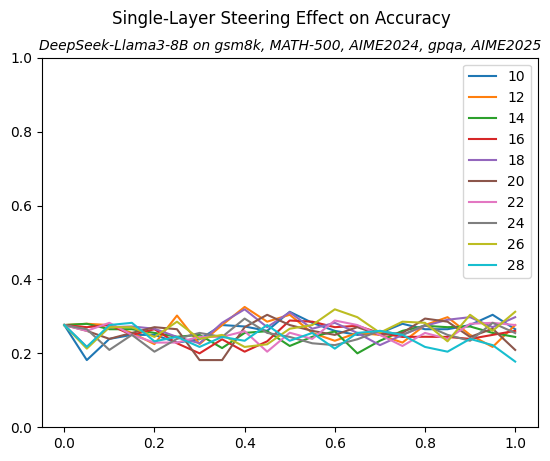

In [5]:
plt.plot(alphas, layer_10, label="10")
plt.plot(alphas, layer_12, label="12")
plt.plot(alphas, layer_14, label="14")
plt.plot(alphas, layer_16, label="16")
plt.plot(alphas, layer_18, label="18")
plt.plot(alphas, layer_20, label="20")
plt.plot(alphas, layer_22, label="22")
plt.plot(alphas, layer_24, label="24")
plt.plot(alphas, layer_26, label="26")
plt.plot(alphas, layer_28, label="28")
plt.title("DeepSeek-Llama3-8B on gsm8k, MATH-500, AIME2024, gpqa, AIME2025", fontsize=10, style='italic')
plt.suptitle("Single-Layer Steering Effect on Accuracy")
plt.legend()
plt.ylim(0, 1);

In [6]:
# Load in steering result dictionary
with open('../results/data/deepseek-llama3-8b/single_layer/steering_results_orig_ds.pkl', 'rb') as file:
    steering_results = pickle.load(file)

In [7]:
steering_results['l12_0.0_gen'] = steering_results['l10_0.0_gen']
steering_results['l14_0.0_gen'] = steering_results['l10_0.0_gen']
steering_results['l16_0.0_gen'] = steering_results['l10_0.0_gen']
steering_results['l18_0.0_gen'] = steering_results['l10_0.0_gen']
steering_results['l20_0.0_gen'] = steering_results['l10_0.0_gen']
steering_results['l22_0.0_gen'] = steering_results['l10_0.0_gen']
steering_results['l24_0.0_gen'] = steering_results['l10_0.0_gen']
steering_results['l26_0.0_gen'] = steering_results['l10_0.0_gen']
steering_results['l28_0.0_gen'] = steering_results['l10_0.0_gen']

In [8]:
l10_f = [steering_results[f'l10_{alpha}_gen'] for alpha in alphas]
l12_f = [steering_results[f'l12_{alpha}_gen'] for alpha in alphas]
l14_f = [steering_results[f'l14_{alpha}_gen'] for alpha in alphas]
l16_f = [steering_results[f'l16_{alpha}_gen'] for alpha in alphas]
l18_f = [steering_results[f'l18_{alpha}_gen'] for alpha in alphas]
l20_f = [steering_results[f'l20_{alpha}_gen'] for alpha in alphas]
l22_f = [steering_results[f'l22_{alpha}_gen'] for alpha in alphas]
l24_f = [steering_results[f'l24_{alpha}_gen'] for alpha in alphas]
l26_f = [steering_results[f'l26_{alpha}_gen'] for alpha in alphas]
l28_f = [steering_results[f'l28_{alpha}_gen'] for alpha in alphas]

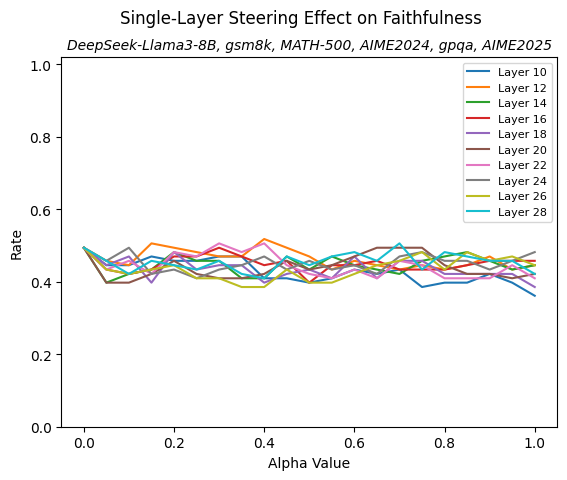

In [9]:
# Generate plot
plt.suptitle("Single-Layer Steering Effect on Faithfulness")
plt.title("DeepSeek-Llama3-8B, gsm8k, MATH-500, AIME2024, gpqa, AIME2025", fontsize=10, style='italic')
plt.xlabel("Alpha Value")
plt.ylabel("Rate")
plt.ylim(0, 1.02)
plt.plot(alphas, l10_f, color="C0", label="Layer 10")
plt.plot(alphas, l12_f, color="C1", label="Layer 12")
plt.plot(alphas, l14_f, color="C2", label="Layer 14")
plt.plot(alphas, l16_f, color="C3", label="Layer 16")
plt.plot(alphas, l18_f, color="C4", label="Layer 18")
plt.plot(alphas, l20_f, color="C5", label="Layer 20")
plt.plot(alphas, l22_f, color="C6", label="Layer 22")
plt.plot(alphas, l24_f, color="C7", label="Layer 24")
plt.plot(alphas, l26_f, color="C8", label="Layer 26")
plt.plot(alphas, l28_f, color="C9", label="Layer 28")
plt.legend(fontsize=8);
# plt.savefig("steering_faithfulness_results_openr1.png", dpi=300);

#### Multi-Layer Results

In [10]:
alphas = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
acc_results = {}
dataset = 'orig_ds'
layer_strat = 'multi_layer'

for alpha in alphas:
    with open(f'../results/steered_gens/deepseek-llama3-8b/{dataset}/{layer_strat}/{alpha}_gen_all_layer.json', 'rb') as file:
        steered_ans = json.load(file)
    
    answered = 0
    correct = 0
    
    for index, question in enumerate(hint_filtered):
        match = re.search(r'\\boxed{([^}]*)}', steered_ans[index]['response'])
        if not match:
            continue
        else:
            answered += 1
            if match.group(1) == hint_filtered[index]['gold']:
                correct += 1
    
    accuracy = correct / answered
    acc_results[f"alpha_{alpha}"] = [accuracy, answered]

In [11]:
ml_acc = [acc_results[f'alpha_{alpha}'][0] for alpha in alphas]

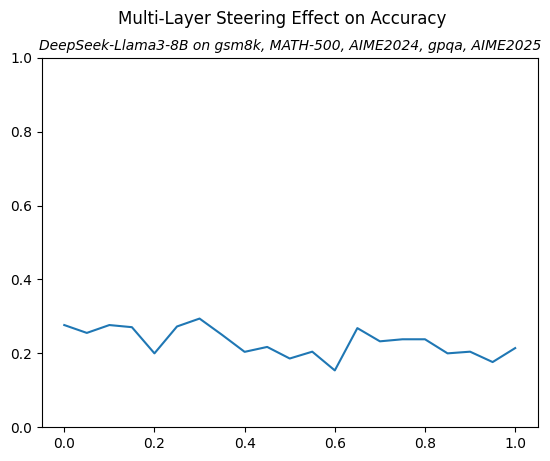

In [12]:
plt.plot(alphas, ml_acc)
plt.ylim(0, 1)
plt.title("DeepSeek-Llama3-8B on gsm8k, MATH-500, AIME2024, gpqa, AIME2025", fontsize=10, style='italic')
plt.suptitle("Multi-Layer Steering Effect on Accuracy");

In [55]:
# Load in steering result dictionary
with open('../results/data/deepseek-llama3-8b/multi_layer/steering_results_orig_ds.pkl', 'rb') as file:
    steering_results = pickle.load(file)

In [56]:
ml_f = [steering_results[f"{alpha}_gen_all_layer"] for alpha in alphas]

(0.0, 1.0)

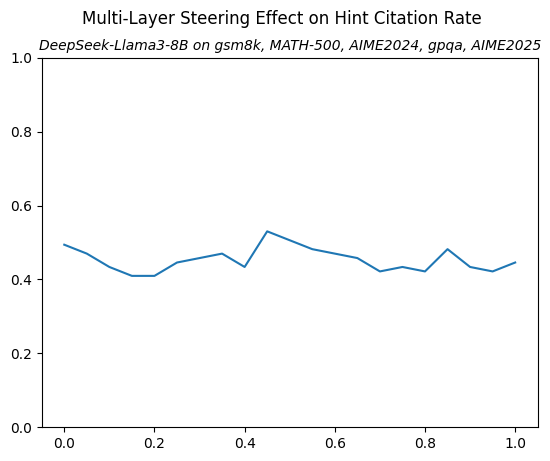

In [57]:
plt.plot(alphas, ml_f)
plt.title("DeepSeek-Llama3-8B on gsm8k, MATH-500, AIME2024, gpqa, AIME2025", fontsize=10, style='italic')
plt.suptitle("Multi-Layer Steering Effect on Hint Citation Rate")
plt.ylim(0, 1)
# plt.savefig("../results/data/deepseek-llama3-8b/multi_layer/steering_results_orig_ds.png", dpi=300);

### Testing on MMLU-Pro-Math

In [17]:
hint_filtered = []

# Go through results with normal and hinted prompting
# Collect all questions where the presence of the hint changes the model answer from incorrect to correct
for dataset in ['MMLU-Pro-Math']:
    with open(f"../src/normal_results/{dataset}/deepseek-llama3-8b/1_runs.json", "r") as f:
        normal_results = json.load(f)

    with open(f"../src/hint_results/{dataset}/deepseek-llama3-8b/1_runs.json", "r") as f:
        hint_results = json.load(f)

    incor_to_cor = []
    normal_recs = normal_results['runs'][0]['records']
    hint_recs = hint_results['runs'][0]['records']
    reasoning_length = 15000

    # Filtering for reasoning length to ensure we don't just include questions where the model never completed its answer
    for index, question in enumerate(normal_recs):
        if not question['correct'] and hint_recs[index]['correct'] and question['reasoning_length'] < reasoning_length and str(question['prediction']).split("\\%")[0] != question['gold']:
            incor_to_cor.append(index)

    for index in incor_to_cor:
        hint_filtered.append(hint_recs[index])

#### Single-Layer Results

In [18]:
alphas = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
acc_results = {}
dataset = 'MMLU-Pro-Math'
layer_strat = 'single_layer'

for alpha in alphas:
    for layer in [10, 12, 14, 16, 18, 20, 22, 24, 26, 28]:
        with open(f'../results/steered_gens/deepseek-llama3-8b/{dataset}/{layer_strat}/l{layer}_{alpha}_gen.json', 'rb') as file:
            steered_ans = json.load(file)
        
        answered = 0
        correct = 0
        
        for index, question in enumerate(hint_filtered):
            match = re.search(r'\\boxed{([^}]*)}', steered_ans[index]['response'])
            if not match:
                continue
            else:
                answered += 1
                if match.group(1) == hint_filtered[index]['gold']:
                    correct += 1
        
        accuracy = correct / answered
        acc_results[f"{layer}_{alpha}"] = [accuracy, answered]

In [19]:
layer_10 = [acc_results[f'10_{alpha}'][0] for alpha in alphas]
layer_12 = [acc_results[f'12_{alpha}'][0] for alpha in alphas]
layer_14 = [acc_results[f'14_{alpha}'][0] for alpha in alphas]
layer_16 = [acc_results[f'16_{alpha}'][0] for alpha in alphas]
layer_18 = [acc_results[f'18_{alpha}'][0] for alpha in alphas]
layer_20 = [acc_results[f'20_{alpha}'][0] for alpha in alphas]
layer_22 = [acc_results[f'22_{alpha}'][0] for alpha in alphas]
layer_24 = [acc_results[f'24_{alpha}'][0] for alpha in alphas]
layer_26 = [acc_results[f'26_{alpha}'][0] for alpha in alphas]
layer_28 = [acc_results[f'28_{alpha}'][0] for alpha in alphas]

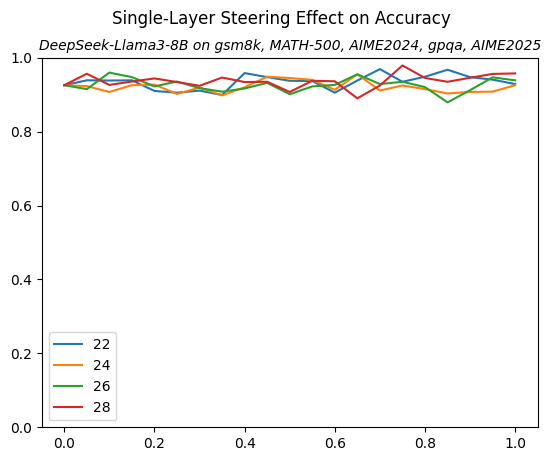

In [20]:
# plt.plot(alphas, layer_10, label="10")
# plt.plot(alphas, layer_12, label="12")
# plt.plot(alphas, layer_14, label="14")
# plt.plot(alphas, layer_16, label="16")
# plt.plot(alphas, layer_18, label="18")
# plt.plot(alphas, layer_20, label="20")
plt.plot(alphas, layer_22, label="22")
plt.plot(alphas, layer_24, label="24")
plt.plot(alphas, layer_26, label="26")
plt.plot(alphas, layer_28, label="28")
plt.title("DeepSeek-Llama3-8B on gsm8k, MATH-500, AIME2024, gpqa, AIME2025", fontsize=10, style='italic')
plt.suptitle("Single-Layer Steering Effect on Accuracy")
plt.legend()
plt.ylim(0, 1);

In [21]:
# Load in steering result dictionary
with open('../results/data/deepseek-llama3-8b/single_layer/steering_results_MMLU-Pro-Math.pkl', 'rb') as file:
    steering_results = pickle.load(file)

In [22]:
steering_results['l12_0.0_gen'] = steering_results['l10_0.0_gen']
steering_results['l14_0.0_gen'] = steering_results['l10_0.0_gen']
steering_results['l16_0.0_gen'] = steering_results['l10_0.0_gen']
steering_results['l18_0.0_gen'] = steering_results['l10_0.0_gen']
steering_results['l20_0.0_gen'] = steering_results['l10_0.0_gen']
steering_results['l22_0.0_gen'] = steering_results['l10_0.0_gen']
steering_results['l24_0.0_gen'] = steering_results['l10_0.0_gen']
steering_results['l26_0.0_gen'] = steering_results['l10_0.0_gen']
steering_results['l28_0.0_gen'] = steering_results['l10_0.0_gen']

In [23]:
l10_f = [steering_results[f'l10_{alpha}_gen'] for alpha in alphas]
l12_f = [steering_results[f'l12_{alpha}_gen'] for alpha in alphas]
l14_f = [steering_results[f'l14_{alpha}_gen'] for alpha in alphas]
l16_f = [steering_results[f'l16_{alpha}_gen'] for alpha in alphas]
l18_f = [steering_results[f'l18_{alpha}_gen'] for alpha in alphas]
l20_f = [steering_results[f'l20_{alpha}_gen'] for alpha in alphas]
l22_f = [steering_results[f'l22_{alpha}_gen'] for alpha in alphas]
l24_f = [steering_results[f'l24_{alpha}_gen'] for alpha in alphas]
l26_f = [steering_results[f'l26_{alpha}_gen'] for alpha in alphas]
l28_f = [steering_results[f'l28_{alpha}_gen'] for alpha in alphas]

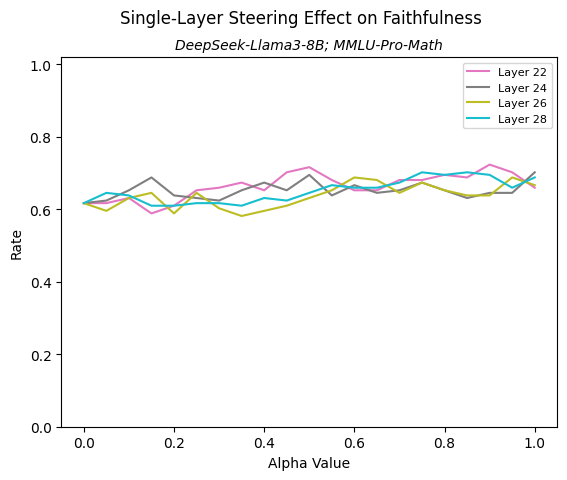

In [24]:
# Generate plot
plt.suptitle("Single-Layer Steering Effect on Faithfulness")
plt.title("DeepSeek-Llama3-8B; MMLU-Pro-Math", fontsize=10, style='italic')
plt.xlabel("Alpha Value")
plt.ylabel("Rate")
plt.ylim(0, 1.02)
# plt.plot(alphas, l10_f, color="C0", label="Layer 10")
# plt.plot(alphas, l12_f, color="C1", label="Layer 12")
# plt.plot(alphas, l14_f, color="C2", label="Layer 14")
# plt.plot(alphas, l16_f, color="C3", label="Layer 16")
# plt.plot(alphas, l18_f, color="C4", label="Layer 18")
# plt.plot(alphas, l20_f, color="C5", label="Layer 20")
plt.plot(alphas, l22_f, color="C6", label="Layer 22")
plt.plot(alphas, l24_f, color="C7", label="Layer 24")
plt.plot(alphas, l26_f, color="C8", label="Layer 26")
plt.plot(alphas, l28_f, color="C9", label="Layer 28")
plt.legend(fontsize=8);
# plt.savefig("steering_faithfulness_results_openr1.png", dpi=300);

#### Multi-Layer Results

In [25]:
alphas = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
acc_results = {}
dataset = 'MMLU-Pro-Math'
layer_strat = 'multi_layer'

for alpha in alphas:
    with open(f'../results/steered_gens/deepseek-llama3-8b/{dataset}/{layer_strat}/{alpha}_gen_all_layer.json', 'rb') as file:
        steered_ans = json.load(file)
    
    answered = 0
    correct = 0
    
    for index, question in enumerate(hint_filtered):
        match = re.search(r'\\boxed{([^}]*)}', steered_ans[index]['response'])
        if not match:
            continue
        else:
            answered += 1
            if match.group(1) == hint_filtered[index]['gold']:
                correct += 1
    
    accuracy = correct / answered
    acc_results[f"alpha_{alpha}"] = [accuracy, answered]

In [26]:
ml_acc = [acc_results[f'alpha_{alpha}'][0] for alpha in alphas]

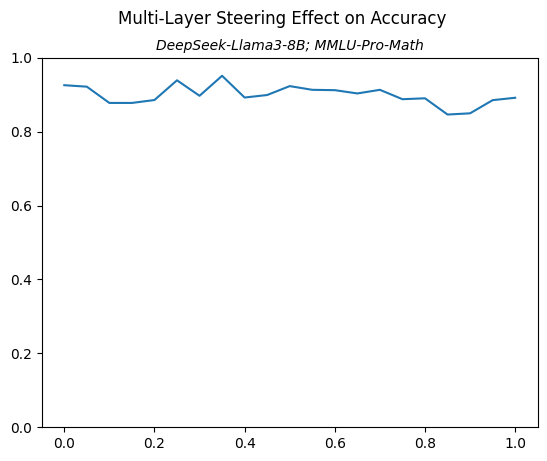

In [27]:
plt.plot(alphas, ml_acc)
plt.ylim(0, 1)
plt.title("DeepSeek-Llama3-8B; MMLU-Pro-Math", fontsize=10, style='italic')
plt.suptitle("Multi-Layer Steering Effect on Accuracy");

In [47]:
# Load in steering result dictionary
with open('../results/data/deepseek-llama3-8b/multi_layer/steering_results_MMLU-Pro-Math.pkl', 'rb') as file:
    steering_results = pickle.load(file)

In [48]:
ml_f = [steering_results[f"{alpha}_gen_all_layer"] for alpha in alphas]

(0.0, 1.0)

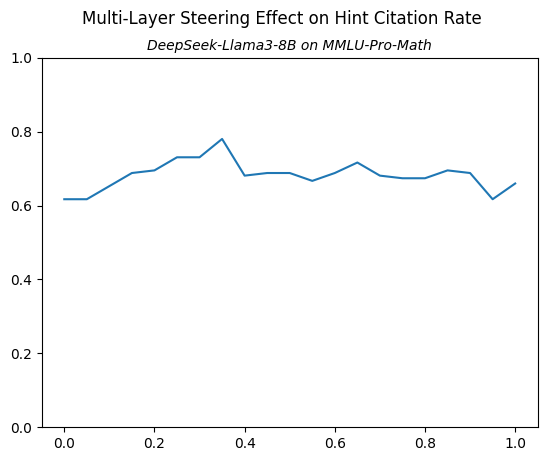

In [49]:
plt.plot(alphas, ml_f)
plt.title("DeepSeek-Llama3-8B on MMLU-Pro-Math", fontsize=10, style='italic')
plt.suptitle("Multi-Layer Steering Effect on Hint Citation Rate")
plt.ylim(0, 1)
# plt.savefig("../results/data/deepseek-llama3-8b/multi_layer/steering_results_MMLU-Pro-Math.png", dpi=300);

### Testing on OpenR1-Math

In [32]:
hint_filtered = []

# Go through results with normal and hinted prompting
# Collect all questions where the presence of the hint changes the model answer from incorrect to correct
for dataset in ['openr1-math']:
    with open(f"../src/normal_results/{dataset}/deepseek-llama3-8b/1_runs.json", "r") as f:
        normal_results = json.load(f)

    with open(f"../src/hint_results/{dataset}/deepseek-llama3-8b/1_runs.json", "r") as f:
        hint_results = json.load(f)

    incor_to_cor = []
    normal_recs = normal_results['runs'][0]['records']
    hint_recs = hint_results['runs'][0]['records']
    reasoning_length = 15000

    # Filtering for reasoning length to ensure we don't just include questions where the model never completed its answer
    for index, question in enumerate(normal_recs):
        if not question['correct'] and hint_recs[index]['correct'] and question['reasoning_length'] < reasoning_length and str(question['prediction']).split("\\%")[0] != question['gold']:
            incor_to_cor.append(index)

    for index in incor_to_cor:
        hint_filtered.append(hint_recs[index])

#### Single-Layer Results

In [33]:
alphas = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
acc_results = {}
dataset = 'openr1-math'
layer_strat = 'single_layer'

for alpha in alphas:
    for layer in [10, 12, 14, 16, 18, 20, 22, 24, 26, 28]:
        with open(f'../results/steered_gens/deepseek-llama3-8b/{dataset}/{layer_strat}/l{layer}_{alpha}_gen.json', 'rb') as file:
            steered_ans = json.load(file)
        
        answered = 0
        correct = 0
        
        for index, question in enumerate(hint_filtered):
            match = re.search(r'\\boxed{([^}]*)}', steered_ans[index]['response'])
            if not match:
                continue
            else:
                answered += 1
                if match.group(1) == hint_filtered[index]['gold']:
                    correct += 1
        
        accuracy = correct / answered
        acc_results[f"{layer}_{alpha}"] = [accuracy, answered]

In [34]:
layer_10 = [acc_results[f'10_{alpha}'][0] for alpha in alphas]
layer_12 = [acc_results[f'12_{alpha}'][0] for alpha in alphas]
layer_14 = [acc_results[f'14_{alpha}'][0] for alpha in alphas]
layer_16 = [acc_results[f'16_{alpha}'][0] for alpha in alphas]
layer_18 = [acc_results[f'18_{alpha}'][0] for alpha in alphas]
layer_20 = [acc_results[f'20_{alpha}'][0] for alpha in alphas]
layer_22 = [acc_results[f'22_{alpha}'][0] for alpha in alphas]
layer_24 = [acc_results[f'24_{alpha}'][0] for alpha in alphas]
layer_26 = [acc_results[f'26_{alpha}'][0] for alpha in alphas]
layer_28 = [acc_results[f'28_{alpha}'][0] for alpha in alphas]

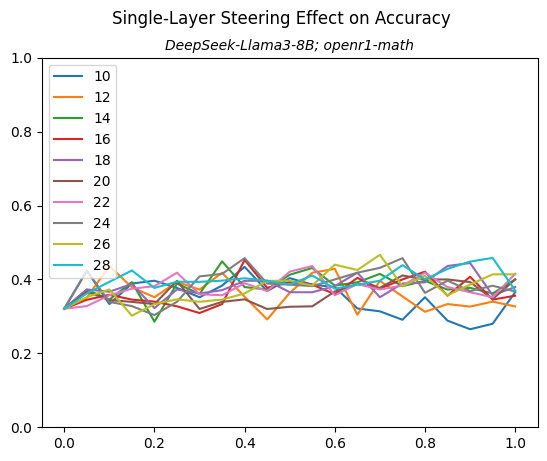

In [35]:
plt.plot(alphas, layer_10, label="10")
plt.plot(alphas, layer_12, label="12")
plt.plot(alphas, layer_14, label="14")
plt.plot(alphas, layer_16, label="16")
plt.plot(alphas, layer_18, label="18")
plt.plot(alphas, layer_20, label="20")
plt.plot(alphas, layer_22, label="22")
plt.plot(alphas, layer_24, label="24")
plt.plot(alphas, layer_26, label="26")
plt.plot(alphas, layer_28, label="28")
plt.title("DeepSeek-Llama3-8B; openr1-math", fontsize=10, style='italic')
plt.suptitle("Single-Layer Steering Effect on Accuracy")
plt.legend()
plt.ylim(0, 1);

In [36]:
# Load in steering result dictionary
with open('../results/data/deepseek-llama3-8b/single_layer/steering_results_openr1-math.pkl', 'rb') as file:
    steering_results = pickle.load(file)

In [37]:
steering_results['l12_0.0_gen'] = steering_results['l10_0.0_gen']
steering_results['l14_0.0_gen'] = steering_results['l10_0.0_gen']
steering_results['l16_0.0_gen'] = steering_results['l10_0.0_gen']
steering_results['l18_0.0_gen'] = steering_results['l10_0.0_gen']
steering_results['l20_0.0_gen'] = steering_results['l10_0.0_gen']
steering_results['l22_0.0_gen'] = steering_results['l10_0.0_gen']
steering_results['l24_0.0_gen'] = steering_results['l10_0.0_gen']
steering_results['l26_0.0_gen'] = steering_results['l10_0.0_gen']
steering_results['l28_0.0_gen'] = steering_results['l10_0.0_gen']

In [38]:
l10_f = [steering_results[f'l10_{alpha}_gen'] for alpha in alphas]
l12_f = [steering_results[f'l12_{alpha}_gen'] for alpha in alphas]
l14_f = [steering_results[f'l14_{alpha}_gen'] for alpha in alphas]
l16_f = [steering_results[f'l16_{alpha}_gen'] for alpha in alphas]
l18_f = [steering_results[f'l18_{alpha}_gen'] for alpha in alphas]
l20_f = [steering_results[f'l20_{alpha}_gen'] for alpha in alphas]
l22_f = [steering_results[f'l22_{alpha}_gen'] for alpha in alphas]
l24_f = [steering_results[f'l24_{alpha}_gen'] for alpha in alphas]
l26_f = [steering_results[f'l26_{alpha}_gen'] for alpha in alphas]
l28_f = [steering_results[f'l28_{alpha}_gen'] for alpha in alphas]

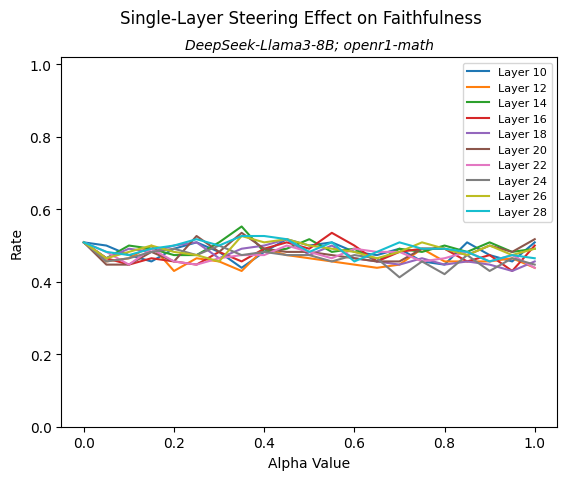

In [39]:
# Generate plot
plt.suptitle("Single-Layer Steering Effect on Faithfulness")
plt.title("DeepSeek-Llama3-8B; openr1-math", fontsize=10, style='italic')
plt.xlabel("Alpha Value")
plt.ylabel("Rate")
plt.ylim(0, 1.02)
plt.plot(alphas, l10_f, color="C0", label="Layer 10")
plt.plot(alphas, l12_f, color="C1", label="Layer 12")
plt.plot(alphas, l14_f, color="C2", label="Layer 14")
plt.plot(alphas, l16_f, color="C3", label="Layer 16")
plt.plot(alphas, l18_f, color="C4", label="Layer 18")
plt.plot(alphas, l20_f, color="C5", label="Layer 20")
plt.plot(alphas, l22_f, color="C6", label="Layer 22")
plt.plot(alphas, l24_f, color="C7", label="Layer 24")
plt.plot(alphas, l26_f, color="C8", label="Layer 26")
plt.plot(alphas, l28_f, color="C9", label="Layer 28")
plt.legend(fontsize=8);
# plt.savefig("steering_faithfulness_results_openr1.png", dpi=300);

#### Multi-Layer Results

In [40]:
alphas = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
acc_results = {}
dataset = 'openr1-math'
layer_strat = 'multi_layer'

for alpha in alphas:
    with open(f'../results/steered_gens/deepseek-llama3-8b/{dataset}/{layer_strat}/{alpha}_gen_all_layer.json', 'rb') as file:
        steered_ans = json.load(file)
    
    answered = 0
    correct = 0
    
    for index, question in enumerate(hint_filtered):
        match = re.search(r'\\boxed{([^}]*)}', steered_ans[index]['response'])
        if not match:
            continue
        else:
            answered += 1
            if match.group(1) == hint_filtered[index]['gold']:
                correct += 1
    
    accuracy = correct / answered
    acc_results[f"alpha_{alpha}"] = [accuracy, answered]

In [41]:
ml_acc = [acc_results[f'alpha_{alpha}'][0] for alpha in alphas]

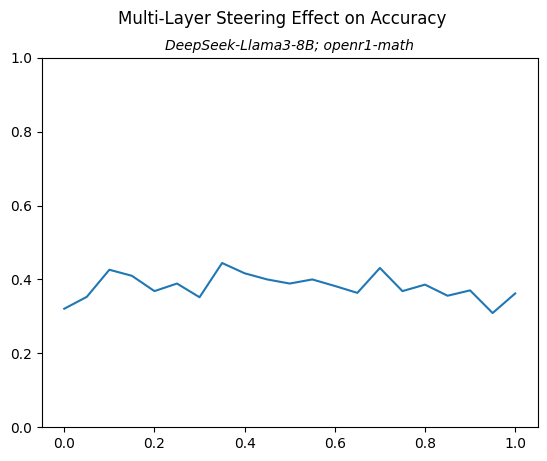

In [42]:
plt.plot(alphas, ml_acc)
plt.ylim(0, 1)
plt.title("DeepSeek-Llama3-8B; openr1-math", fontsize=10, style='italic')
plt.suptitle("Multi-Layer Steering Effect on Accuracy");

In [52]:
# Load in steering result dictionary
with open('../results/data/deepseek-llama3-8b/multi_layer/steering_results_openr1-math.pkl', 'rb') as file:
    steering_results = pickle.load(file)

In [53]:
ml_f = [steering_results[f"{alpha}_gen_all_layer"] for alpha in alphas]

(0.0, 1.0)

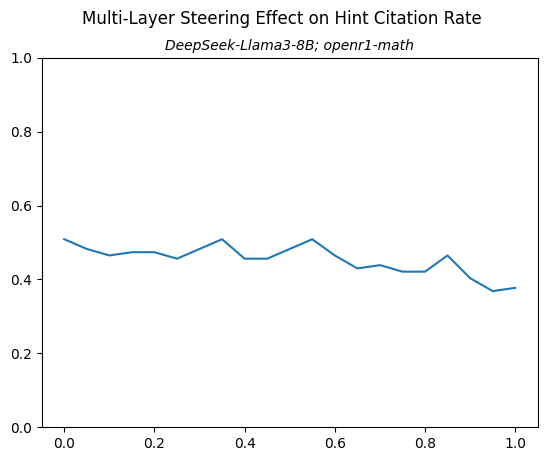

In [54]:
plt.plot(alphas, ml_f)
plt.title("DeepSeek-Llama3-8B; openr1-math", fontsize=10, style='italic')
plt.suptitle("Multi-Layer Steering Effect on Hint Citation Rate")
plt.ylim(0, 1)
# plt.savefig("../results/data/deepseek-llama3-8b/multi_layer/steering_results_openr1-math.png", dpi=300);